In [6]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [7]:
import pandas as pd
import numpy as np
from forecast.metrics import crps, calculate_crps_scores
# plot CRPS scores for each horizon
import matplotlib.pyplot as plt

In [8]:
reals = pd.read_csv('debug_logs/real_power_point_and_variance_9000_gmm_14march_1.csv')
reals = reals.iloc[1:, :]
reals = reals.melt(id_vars=['time_step'], var_name='building', value_name='net_target')
reals = reals.sort_values(by=['time_step', 'building'])
reals['building'] = reals['building'].str[-1].astype(int)
reals = reals[reals['time_step'] != -1]
lead_times = ['net_target+'+str(i) for i in range(2, 25)]
reals_h24 = pd.DataFrame()
for building in range(5):
    reals_h24_temp = pd.DataFrame()
    reals_h24_temp['time_step'] = reals.loc[reals['building'] == building, 'time_step']
    reals_h24_temp['building'] = building
    reals_h24_temp['net_target+1'] = reals.loc[reals['building'] == building, 'net_target']
    for i, lead_time in enumerate(lead_times):
        reals_h24_temp[lead_time] = reals_h24_temp['net_target+1'].shift(-int(i+1))
    reals_h24 = pd.concat([reals_h24, reals_h24_temp], axis=0)
reals_h24 = reals_h24.dropna()
# reals time_step as int
reals_h24 = reals_h24.sort_values(by=['time_step', 'building'])
# set the index to time_step and building
reals_h24 = reals_h24.set_index(['time_step', 'building'], drop=False)
reals_h24

time_step  building  net_target+1  net_target+2  \
time_step building                                                    
0         0                 0         0  8.511667e-01  8.346000e-01   
          1                 0         1  1.370667e+00  1.101250e+00   
          2                 0         2  1.018524e-07  1.008352e-07   
          3                 0         3  1.928167e+00  4.758167e-01   
          4                 0         4  5.158833e-01  5.030500e-01   
...                       ...       ...           ...           ...   
8735      0              8735         0  1.581708e+00  5.796833e-01   
          1              8735         1  2.289758e+00  5.151167e-01   
          2              8735         2  7.067500e-01  4.349000e-01   
          3              8735         3  3.510683e+00  2.099967e+00   
          4              8735         4  1.343600e+00  9.951167e-01   

                    net_target+3  net_target+4  net_target+5  net_target+6  \
time_step building                                                           
0         0         8.381667e-01  1.478433e+00  1.256200e+00      1.811500   
          1         5.432167e-01  5.428333e-01  1.512433e+00      0.326250   
          2         1.007080e-07  1.015981e-07  9.943644e-08     -0.027283   
          3         4.582333e-01  4.460167e-01  4.658833e-01      0.637133   
          4         5.359500e-01  5.126167e-01  3.032167e-01      0.378583   
...                          ...           ...           ...           ...   
8735      0         5.926500e-01  5.763333e-01  5.861833e-01      0.590600   
          1         7.532500e-01  7.767167e-01  1.895200e+00      0.350383   
          2         4.231333e-01  4.464667e-01  3.864667e-01      0.377350   
          3         2.567050e+00  5.842667e-01  7.306833e-01      1.942067   
          4         9.510333e-01  6.088167e-01  5.943000e-01      0.376467   

                    net_target+7  net_target+8  ...  net_target+15  \
time_step building                              ...                  
0         0             0.362733     -0.489917  ...      -0.595117   
          1             0.560617      1.119483  ...       0.935333   
          2            -0.136700     -0.034533  ...      -1.413883   
          3             0.698950      2.152567  ...      -1.972850   
          4             0.274750     -0.070083  ...      -0.109050   
...                          ...           ...  ...            ...   
8735      0             0.770317      0.220983  ...      -0.199817   
          1             0.319250      0.222683  ...       0.944117   
          2             0.314100      0.235600  ...      -1.414011   
          3             0.466517      0.851900  ...       0.192433   
          4             0.444233     -0.149983  ...       0.522200   

                    net_target+16  net_target+17  net_target+18  \
time_step building                                                
0         0             -0.298267       0.059700       1.054850   
          1              0.204017      -0.572450      -0.678733   
          2             -1.743550      -1.656633      -0.879733   
          3             -2.074017      -0.055433       0.160417   
          4             -0.137150       0.023717       2.313683   
...                           ...            ...            ...   
8735      0              0.115850       0.803650       2.636517   
          1              1.083967      -1.310933      -1.106450   
          2             -0.635250      -0.525617       0.284317   
          3             -0.329417       0.222217       1.017867   
          4              1.169617       1.663533       3.119600   

                    net_target+19  net_target+20  net_target+21  \
time_step building                                                
0         0              1.006983   3.603983e+00   5.008500e+00   
          1             -0.069417   3.583334e-01   1.584500e+00   
          2             -0.045

In [28]:
# open csv file for scenarios
scens_gmm = pd.read_csv('debug_logs/scenarios_point_and_variance_9000_1_gmm_16march.csv')
# remove rows with time_step 8759
scens_gmm = scens_gmm[scens_gmm['time_step'] != 8759]
scens_normal = pd.read_csv('debug_logs/scenarios_point_and_variance_9000_1_norm_16march.csv')
scens_normal = scens_normal[scens_normal['time_step'] != 8759]
scens_covariance = pd.read_csv('debug_logs/scenarios_full_covariance_9000_1_0means_15march.csv')
scens_covariance = scens_covariance[scens_covariance['time_step'] != 8759]
scens_point = pd.read_csv('debug_logs/scenarios_point_recurrent_9000_1.csv')
scens_point = scens_point[scens_point['time_step'] != 8759]
# set time_step and building as index
scens_gmm = scens_gmm.set_index(['time_step', 'building'], drop=False)
scens_normal = scens_normal.set_index(['time_step', 'building'], drop=False)
scens_covariance = scens_covariance.set_index(['time_step', 'building'], drop=False)
scens_point = scens_point.set_index(['time_step', 'building'], drop=False)
# keep only indexes that are in reals
scens_gmm = scens_gmm.loc[reals_h24.index]
scens_normal = scens_normal.loc[reals_h24.index]
scens_covariance = scens_covariance.loc[reals_h24.index]
scens_point = scens_point.loc[reals_h24.index]

In [41]:
bins_gmm = rank_bins(scens_gmm, reals_h24)
bins_normal = rank_bins(scens_normal, reals_h24)
bins_covariance = rank_bins(scens_covariance, reals_h24)

In [39]:
def rank_bins(scens, reals):
    # for each lead time, find the bin that the real value is in
    bins = []
    # loop over steps ahead
    for step in scens['time_step'].unique():
        # loop over buildings
        for building in scens['building'].unique():
            temp = scens.loc[(scens['time_step'] == step) & (scens['building'] == building)]
            for i in range(1, 25):
                build_col = 'building_{}'.format(building)
                real_value = reals.loc[(reals['time_step'] == step) & (reals['building'] == building)]
                column_name = '+{}h'.format(i)
                net_target_col_name = 'net_target+{}'.format(i)
                bin_number = temp[column_name].sort_values().reset_index(drop=True).searchsorted(real_value[net_target_col_name].values[0])
                bins.append(bin_number)
    return bins

In [40]:
reals_h24.loc[(reals_h24['time_step'] == 300) & (reals_h24['building'] == 0)]['net_target+1'].values[0]

-1.2955833333333375

In [32]:
temp = scens.loc[(scens['time_step'] == 300) & (scens['building'] == 0)]
column_name = '+{}h'.format(1)
temp[column_name].sort_values().reset_index(drop=True)

0   -2.607821
1   -2.309755
2   -1.229543
3   -1.177863
4   -1.171790
5   -1.153882
6   -1.081402
7   -0.946923
8   -0.889747
9   -0.742582
Name: +1h, dtype: float64

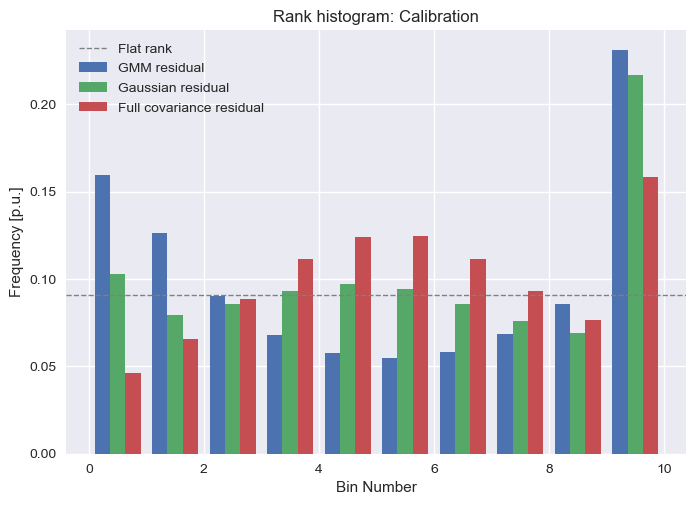

In [47]:
labels = ['GMM residual', 'Gaussian residual', 'Full covariance residual']
plot_bins([bins_gmm, bins_normal, bins_covariance], labels)
plt.legend()
# show the plot
plt.show()

In [46]:
def plot_bins(bins_list, labels_var):
    # plot bin frequencies in per unit for bins and bins_recur next to each other
    plt.hist(bins_list, density=True, linewidth=2, fill=True, label=labels_var)
    # make it pretty
    plt.title('Rank histogram: Calibration')
    plt.xlabel('Bin Number')
    plt.ylabel('Frequency [p.u.]')
    # set style to b&w
    plt.style.use('seaborn')
    # mark the probability of the real value falling in the bin
    plt.axhline(y=1/11, color='grey', linestyle='--', linewidth=1, label='Flat rank')